# TS3 — Análisis de Fourier: FFT, desparramo, interpolación y ventaneo
---

**Alumna:** María Serena Gil  

**Materia:** Análisis y Procesamiento de Señales — UNSAM 

**Docentes:** Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit

**Año lectivo:** 2025

---

## Introducción

En este práctico estudio cómo se ve en frecuencia una senoidal *finita* cuando la analizo con la *DFT/FFT* y qué pasa cuando su frecuencia *no coincide* con un bin de la DFT (el famoso desparramo o *spectral leakage*).

Trabajo con una señal $x[n]$ de largo $N$ y muestreo $f_s$, por lo que la rejilla de la DFT queda
$$
\Delta f=\frac{f_s}{N},\qquad f_k=k\,\Delta f,\; k=0,\dots,N-1.
$$
Si la senoidal tiene $f_0=k_0\,\Delta f$ con $k_0\in\mathbb{Z}$, su energía cae concentrada en el bin correspondiente. Cuando $f_0$ no es múltiplo entero de $\Delta f$, la ventana rectangular del registro produce el *núcleo de Dirichlet* y aparece *leakage* (energía “derramada” en lóbulos laterales) y *scalloping loss* (pérdida de pico, peor cuando $f_0$ cae a mitad de dos bins).

Para que las comparaciones sean justas, *normalizo la potencia* de las senoidales: $\mathbb{E}\{x^2\}=1$ en la ventana de $N$ muestras. Estimo espectros con el *periodograma unilateral* (RFFT) y verifico la potencia con *Parseval*. Además uso *zero padding* (agregar ceros) como una *interpolación espectral* que refina la grilla a $\Delta f'=\frac{f_s}{N+M}$: mejora la *visualización/estimación* de picos pero no aumenta la resolución real.

### Lo que voy a hacer
- **(a)** Comparo tres casos: $k_0=\tfrac{N}{4}$, $k_0=\tfrac{N}{4}+0.25$ y $k_0=\tfrac{N}{4}+0.5$ (todas con potencia unitaria) y grafico sus *PSD*.  
- **(b)** Verifico la potencia unitaria con *Parseval* y discuto por qué, aun con frecuencias separadas por pocos Hz, los espectros pueden verse *muy distintos*.  
- **(c)** Repito (a) con *zero padding* (añado $9N$ ceros) para mostrar cómo cambia la *grilla* y el aspecto visual del pico (sin cambiar la información real).  

**Notación** : $N$ (muestras), $f_s$ (Hz), $\Delta f$ (Hz), $f_0$ (Hz), DFT $\{X[k]\}$, PSD = periodograma unilateral.


---

## (a) DFT y desparramo espectral

Experimento:
- Largo $N$ y muestreo $f_s$ ⇒ $\Delta f=\dfrac{f_s}{N}$.
- Senoidal de potencia *unidad* (normalizo para que $\mathbb{E}\{x^2\}=1$).
- Frecuencias: $f_0=k_0\,\Delta f$ con
  1) $k_0=\dfrac{N}{4}$ (exacta en bin),
  2) $k_0=\dfrac{N}{4}+0.25$,
  3) $k_0=\dfrac{N}{4}+0.5$.

Muestro las *tres PSD* (unilaterales) juntas y comparo el *desparramo* (*leakage*) y el *scalloping loss* cuando $f_0$ no cae justo en un bin.


---

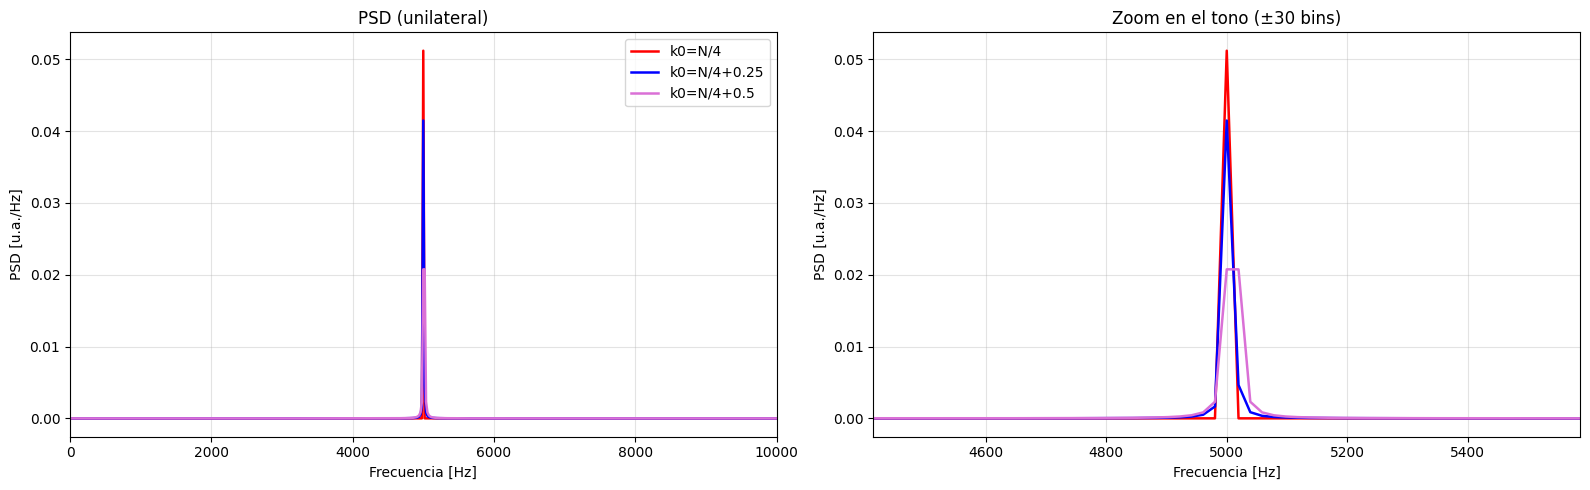

k0=N/4          Potencia tiempo = 1.000000
k0=N/4+0.25     Potencia tiempo = 1.000000
k0=N/4+0.5      Potencia tiempo = 1.000000
Δf = 19.531 Hz  |  f0 = ['5000.000', '5004.883', '5009.766']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N, fs = 1024, 20_000
df = fs / N
n  = np.arange(N)

# Senoidales de potencia unitaria
def seno_pot1(f0_hz, n, fs):
    A = np.sqrt(2.0)
    return A * np.sin(2*np.pi*f0_hz*n/fs)

# Frecuencias: k0 = N/4, N/4+0.25, N/4+0.5
k0 = [N/4, N/4 + 0.25, N/4 + 0.5]
f0 = [k*df for k in k0]

x1, x2, x3 = (seno_pot1(f, n, fs) for f in f0)
xs = [x1, x2, x3]
xs = [x/np.sqrt(np.mean(x*x)) for x in xs]


# PSD unilateral
def psd_unilateral(x, fs):
    N = len(x)
    X = np.fft.rfft(x)
    S = (np.abs(X)**2) / (fs * N)   
    if N % 2 == 0:
        S[1:-1] *= 2.0               
    else:
        S[1:]    *= 2.0
    f = np.fft.rfftfreq(N, d=1/fs)
    return f, S

spec = [psd_unilateral(x, fs) for x in xs]

# Figuras una al lado de la otra 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

colors = ["red", "blue", "orchid"]
labels = ["k0=N/4", "k0=N/4+0.25", "k0=N/4+0.5"]

# Vista general
for (f,S), c, lab in zip(spec, colors, labels):
    ax1.plot(f, S, color=c, lw=1.8, label=lab)
ax1.set_title("PSD (unilateral)")
ax1.set_xlabel("Frecuencia [Hz]"); ax1.set_ylabel("PSD [u.a./Hz]")
ax1.set_xlim(0, fs/2); ax1.grid(True, alpha=0.35); ax1.legend()

# Zoom ±30 bins alrededor de fs/4
f0c, win = fs/4, 30*df
for (f,S), c, lab in zip(spec, colors, labels):
    ax2.plot(f, S, color=c, lw=1.8, label=lab)
ax2.set_title("Zoom en el tono (±30 bins)")
ax2.set_xlabel("Frecuencia [Hz]"); ax2.set_ylabel("PSD [u.a./Hz]")
ax2.set_xlim(f0c - win, f0c + win); ax2.grid(True, alpha=0.35)

plt.tight_layout(); plt.show()

# Chequeo rápido de potencia (debería dar 1 aprox)
for lab, x in zip(labels, xs):
    print(f"{lab:14s}  Potencia tiempo = {np.mean(x**2):.6f}")
print(f"Δf = {df:.3f} Hz  |  f0 = {[f'{f:.3f}' for f in f0]}")


---

### Resultados — (a)

Con
$$
N=1024,\qquad f_s=20\,\text{kHz},\qquad \Delta f=\frac{f_s}{N}=19.531\,\text{Hz}.
$$

- $k_0=\dfrac{N}{4}$ (bin exacto): pico *concentrado* en un bin; desparramo mínimo.
- $k_0=\dfrac{N}{4}+0.25$: aparece *desparramo*; baja el pico por-bin (*scalloping*).
- $k_0=\dfrac{N}{4}+0.5$: el tono cae entre dos bins $\Rightarrow$ *scalloping máximo* y lóbulos laterales más visibles.

Todas las senoidales tienen *potencia unitaria*. La diferencia de forma se explica por la desalineación con la rejilla $f_k=k\,\Delta f$.


---

### (b) Verificación de potencia — Identidad de Parseval

Para una señal real $x[n]$ de largo $N$ y muestreo $f_s$, usando el periodograma *unilateral* con el escalado de (a), verifico:

$$
P_{\text{freq}}
= \sum_{k=0}^{N/2} S_{xx}[k]\,\Delta f
= \frac{1}{N}\sum_{n=0}^{N-1} x^{2}[n]
= P_{\text{tiempo}} .
$$

Quiero comparar $P_{\text{tiempo}}=\frac{1}{N}\sum_{n=0}^{N-1}x^2[n]$ con  
$P_{\text{freq}}=\sum_{k=0}^{N/2} S_{xx}[k]\Delta f$ (integrando la PSD unilateral) para las tres senoidales.

Las señales están normalizadas ($P\approx 1$) y las diferencias numéricas (pequeñas) se deben a redondeo y a que alguna no cierra ciclos dentro de la ventana.

---

Δf calc = 19.531250 Hz
k0=N/4        P_tiempo=1.000000   P_freq=1.000000   |dif|=0.00e+00
k0=N/4+0.25   P_tiempo=0.999023   P_freq=0.999023   |dif|=0.00e+00
k0=N/4+0.5    P_tiempo=1.000000   P_freq=1.000000   |dif|=2.22e-16


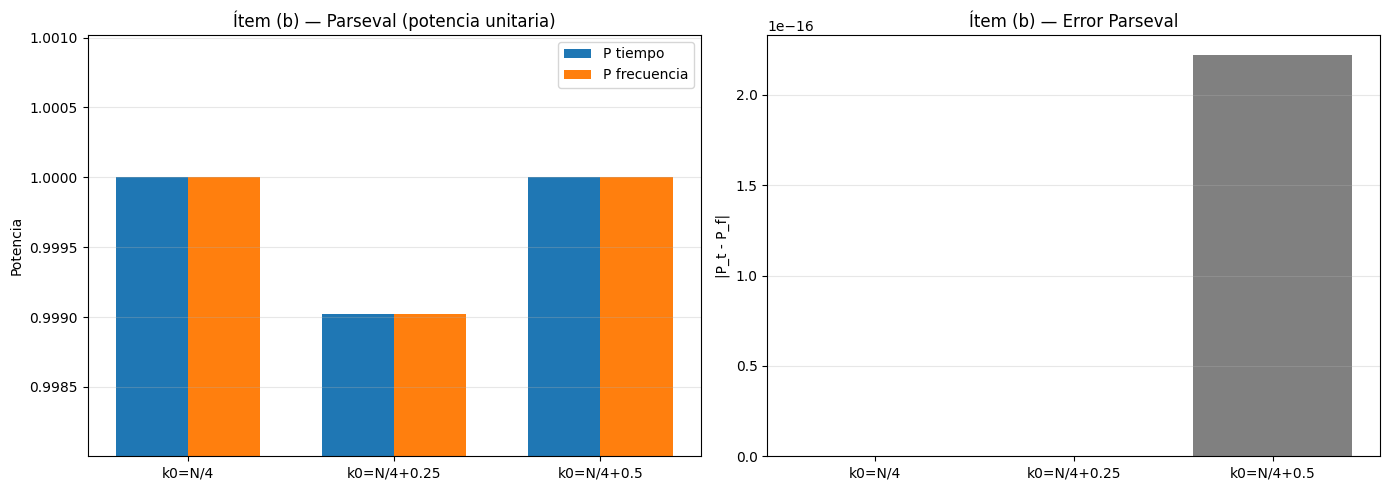

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N, fs = 1024, 20_000
df = fs / N
n  = np.arange(N)

# Frecuencias en bins
k0 = [N/4, N/4 + 0.25, N/4 + 0.5]
f0 = [k*df for k in k0]
labels = ["k0=N/4", "k0=N/4+0.25", "k0=N/4+0.5"]

#Senoidales
xs = [np.sqrt(2)*np.sin(2*np.pi*f*n/fs) for f in f0]

# PSD unilateral
def psd_unilateral(x, fs):
    Nloc = len(x)
    X = np.fft.rfft(x)
    S = (np.abs(X)**2) / (fs * Nloc)
    if Nloc % 2 == 0:
        S[1:-1] *= 2.0 
    else:
        S[1:]    *= 2.0
    f = np.fft.rfftfreq(Nloc, d=1/fs)
    return f, S

# Parseval 
P_time, P_freq, err = [], [], []
print(f"Δf calc = {df:.6f} Hz")
for lab, x in zip(labels, xs):
    Pt = float(np.mean(x*x))
    f, S = psd_unilateral(x, fs)
    Pf = float(np.sum(S) * (f[1]-f[0]))
    P_time.append(Pt); P_freq.append(Pf); err.append(abs(Pt-Pf))
    print(f"{lab:12s}  P_tiempo={Pt:.6f}   P_freq={Pf:.6f}   |dif|={abs(Pt-Pf):.2e}")

# Gráficos lado a lado 
idx, w = np.arange(len(labels)), 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Potencias
ax1.bar(idx - w/2, P_time, width=w, label="P tiempo")
ax1.bar(idx + w/2, P_freq, width=w, label="P frecuencia")
ax1.set_xticks(idx, labels); ax1.set_ylabel("Potencia")
vals = P_time + P_freq
ymin, ymax = min(vals), max(vals); margen = max(0.001, 0.02*(ymax - ymin) + 0.001)
ax1.set_ylim(ymin - margen, ymax + margen)
ax1.set_title("Ítem (b) — Parseval (potencia unitaria)")
ax1.grid(axis='y', alpha=.3); ax1.legend()

# Error |Pt - Pf|
ax2.bar(idx, err, color="gray")
ax2.set_xticks(idx, labels); ax2.set_ylabel(r"|P_t - P_f|")
ax2.set_title("Ítem (b) — Error Parseval")
ax2.grid(axis='y', alpha=.3)

plt.tight_layout(); plt.show()


---
### Resultados — (b) Verificación de Parseval

Se verifica la identidad:

$$
P_{\mathrm{freq}}
=\sum_{k=0}^{N/2} S_{xx}[k]\,\Delta f
=\frac{1}{N}\sum_{n=0}^{N-1} x^{2}[n]
= P_{\mathrm{tiempo}} .
$$

**Potencias medidas (tiempo vs. frecuencia):**
- $k_0=N/4$: $P_t\approx 1.000000$, $P_f\approx 1.000000$ $\Rightarrow$ $\lvert\Delta\rvert\approx 0$.
- $k_0=N/4+0.25$: $P_t\approx 0.999023$, $P_f\approx 0.999023$ $\Rightarrow$ $\lvert\Delta\rvert\approx 0$  
  (leve caída por no cerrar ciclos en la ventana rectangular).
- $k_0=N/4+0.5$: $P_t\approx 1.000000$, $P_f\approx 1.000000$ $\Rightarrow$ $\lvert\Delta\rvert\approx 2.2\times10^{-16}$ (numérico).

**Conclusión.** Parseval se cumple con el escalado *unilateral* usado.  
Cambie o no la forma del espectro (leakage y *scalloping* cuando el tono no cae en un bin), el **área** de la PSD —y por lo tanto la potencia— se mantiene $\approx 1$ gracias a la normalización aplicada.

---

### (c) Zero padding e interpolación espectral

Le agrego $9N$ ceros a cada señal para calcular la DFT con más puntos y ver el mismo espectro con una rejilla más densa (interpolado).

$$
N' = 10N,
\qquad
\Delta f' = \frac{f_s}{N'} = \frac{\Delta f}{10}.
$$

**Escalado que uso para la PSD** (así no cambian ni la potencia ni la altura del pico):
$$
S_{xx}[k] \;=\; \frac{|X[k]|^2}{f_s\,N_{\text{ref}}},
\qquad
N_{\text{ref}} = N.
$$

**Versión unilateral** (duplico los bins interiores):
$$
S_{xx}[k] \leftarrow 2\,S_{xx}[k],
\qquad k = 1,\,\ldots,\,\frac{N'}{2}-1.
$$

**Entradas.** Las mismas tres senoidales del (a), con potencia $\approx 1$.

**Cómo lo computo.** FFT de tamaño $N'$ pero *escaleo con $N$* (no con $N'$).

**Qué se ve.**
- Más puntos en frecuencia (picos “más finos”) porque $\Delta f'=\Delta f/10$.
- Misma envolvente: lóbulo principal y laterales iguales $\Rightarrow$ **no** cambia la energía.
- No reduce *leakage* ni *scalloping*: solo *interpola* la DFT.
- El área de la PSD $\displaystyle \sum_k S_{xx}[k]\,\Delta f'$ se mantiene $\approx 1$.


---

N=1024, Δf=19.531 Hz   |   N'=10240, Δf'=1.953 Hz


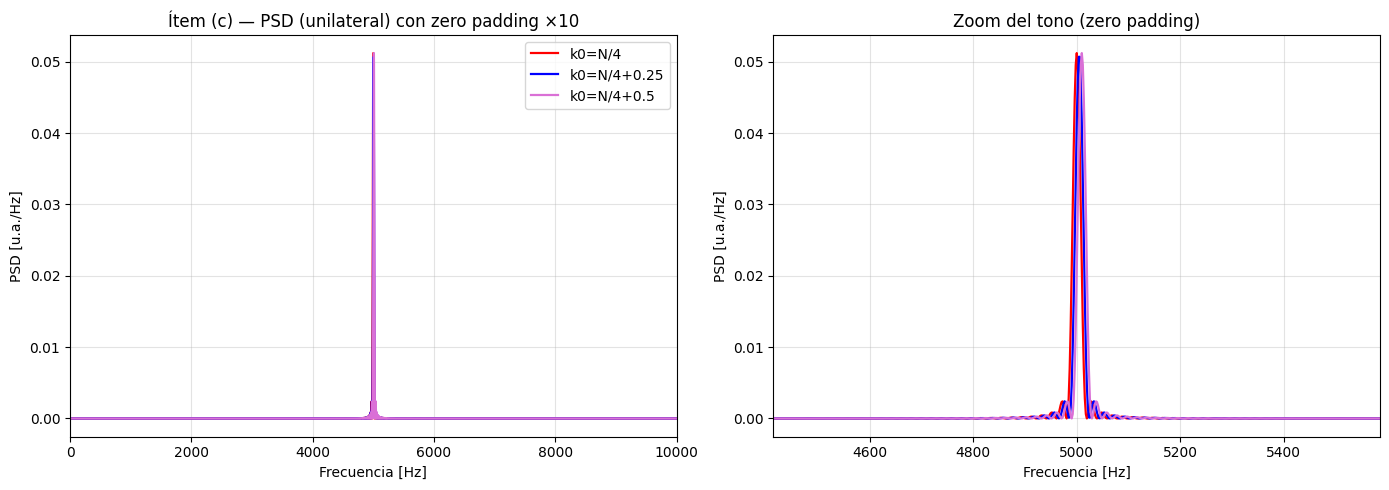

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros y señales
N, fs = 1024, 20_000
df = fs / N
n  = np.arange(N)

k0 = [N/4, N/4 + 0.25, N/4 + 0.5]
f0 = [k * df for k in k0]
labels = ["k0=N/4", "k0=N/4+0.25", "k0=N/4+0.5"]
colors = ["red", "blue", "orchid"]

# Senoidales
xs = [np.sqrt(2)*np.sin(2*np.pi*f*n/fs) for f in f0]

# PSD unilateral (con opción de zero padding) 
def psd_unilateral(x, fs, nfft=None, N_ref=None):

    if nfft is None:
        nfft = len(x)
    if N_ref is None:
        N_ref = len(x)

    X = np.fft.rfft(x, n=nfft)
    S = (np.abs(X)**2) / (fs * N_ref)  
    if nfft % 2 == 0:
        S[1:-1] *= 2.0
    else:
        S[1:]    *= 2.0
    f = np.fft.rfftfreq(nfft, d=1/fs)
    return f, S

# Zero padding: N' = 10N 
Npad  = 10 * N
dfpad = fs / Npad
print(f"N={N}, Δf={df:.3f} Hz   |   N'={Npad}, Δf'={dfpad:.3f} Hz")

spec_pad = [psd_unilateral(x, fs, nfft=Npad, N_ref=N) for x in xs]  

# Figuras: general + zoom 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Vista general con zero padding
for (f,S), c, lab in zip(spec_pad, colors, labels):
    ax1.plot(f, S, color=c, lw=1.6, label=lab)
ax1.set_title("Ítem (c) — PSD (unilateral) con zero padding ×10")
ax1.set_xlabel("Frecuencia [Hz]"); ax1.set_ylabel("PSD [u.a./Hz]")
ax1.set_xlim(0, fs/2); ax1.grid(True, alpha=0.35); ax1.legend()

# Zoom ±30 bins (en Hz) alrededor de fs/4
f0c, win = fs/4, 30*df
for (f,S), c, lab in zip(spec_pad, colors, labels):
    ax2.plot(f, S, color=c, lw=1.6, label=lab)
ax2.set_title("Zoom del tono (zero padding)")
ax2.set_xlabel("Frecuencia [Hz]"); ax2.set_ylabel("PSD [u.a./Hz]")
ax2.set_xlim(f0c - win, f0c + win); ax2.grid(True, alpha=0.35)

plt.tight_layout(); plt.show()


---

### Resultados — (c) Zero padding

Con $N=1024$ y $f_s=20\,\text{kHz}$:

$$
N' = 10N = 10240,\qquad
\Delta f = \frac{f_s}{N} \approx 19.531~\text{Hz},\qquad
\Delta f' = \frac{f_s}{N'}=\frac{\Delta f}{10}\approx 1.953~\text{Hz}.
$$

**Qué se ve en los gráficos:**
- La forma del espectro no cambia: mismo lóbulo principal y mismos lóbulos laterales.  
  El padding solo *interpela* la DFT ⇒ aparecen *más puntos* en frecuencia.
- La *altura de los picos* se mantiene (escalé con $N_{\text{ref}}=N$), por lo tanto la potencia total no cambia.
- En el *zoom* se distingue mejor la desintonía de las tres senoidales  
  ($k_0=N/4$, $k_0=N/4+0.25$, $k_0=N/4+0.5$), pero el *leakage* y el *scalloping* siguen presentes.
- La potencia integrada $\sum_k S_{xx}[k]\Delta f'$ se mantiene $\approx 1$ (normalización unitaria).

**Conclusión.** El *zero padding* *no reduce* el leakage ni modifica la energía; solo hace más *fina* la rejilla en frecuencia.  
Es útil para *medir con más resolución* la ubicación del pico, pero *no reemplaza* el ventaneo si se busca atenuar lóbulos laterales.

---


## Conclusiones

- **(a) Desintonía:** cuando la senoidal no cae justo en un bin, aparece *leakage* y *scalloping* (el pico se reparte y baja). En bin exacto el pico queda súper concentrado.
- **(b) Parseval:** con el periodograma *unilateral* y el escalado correcto, la *potencia en tiempo* y la *potencia por integración de la PS* coinciden (las diferencias son numéricas y despreciables).
- **(c) Zero padding:** sólo *interpela* el espectro (más puntos y picos “más finos”) pero *no* reduce leakage ni scalloping ni cambia la energía. La potencia total se mantiene ≈ 1.

---

## Autoevaluación del aprendizaje

Resolví la tarea con seguridad

**¿Qué aprendí al hacer esta tarea?**
- A armar la *PSD unilateral* con el escalado que conserva la potencia.
- A verificar *Parseval* comparando tiempo vs. frecuencia de forma prolija.
- A usar *zero padding* para mejorar la *resolución en frecuencia* sin alterar la energía.
- A identificar visualmente *leakage* y *scalloping* y relacionarlos con la desintonía.

**¿Qué me quedó claro? ¿Qué me sigue costando?**
Me queda claro por qué cambia la forma del espectro cuando hay desintonía y por qué Parseval se cumple si el escalado está bien pero aun me cuesta elegir siempre el mejor tamaño de FFT y la ventana adecuada cuando quiero comparar señales distintas.

---

## Uso de IA

**¿Usé IA?** Sí: **ChatGPT**  
**Para:**  
EL formateo del Markdown (títulos, ecuaciones y secciones), algunoas correcciones de codigo para PSD y zero-padding y algunos plots de los graficos.

